# Learned prompt variable injection via rl chain

The rl_chain (reinforcement learning chain) is used primarily for prompt variable injection: when we want to enhance a prompt with a value but we are not sure which of the available variable values will make the prompt achieve what we want.

It provides a way to learn a specific prompt engineering policy without fine tuning the underlying foundational model.

The example layed out below is trivial and a strong llm could make a good variable selection and injection without the intervention of this chain, but it is perfect for showcasing the chain's usage. Advanced options and explanations are provided at the end.

The goal of the below scenario is for the chain to select a meal based on the user declared preferences, and inject the meal into the prompt template. The final prompt will then be sent to the llm of choice and the llm output will be returned to the user.

In [1]:
# four meals defined, some vegetarian some not

meals = [
    "Beef Enchiladas with Feta cheese. Mexican-Greek fusion",
    "Chicken Flatbreads with red sauce. Italian-Mexican fusion",
    "Veggie sweet potato quesadillas with vegan cheese",
    "One-Pan Tortelonni bake with peppers and onions",
]

In [2]:
# pick and configure the LLM of your choice

from langchain.llms import OpenAI
llm = OpenAI(engine="text-davinci-003")

llm.predict("are you ready?")

"\n\nYes, I'm ready."

##### Intialize the rl chain with provided defaults

The prompt template which will be used to query the LLM needs to be defined.
It can be anything, but here `{meal}` is being used and is going to be replaced by one of the meals above, the rl chain will try to pick and inject the best meal


In [3]:
from langchain.prompts import PromptTemplate

# here I am using the variable meal which will be replaced by one of the meals above
# and some variables like user, preference, and text_to_personalize which I will provide at chain run time

PROMPT_TEMPLATE = """Here is the description of a meal: "{meal}".

Embed the meal into the given text: "{text_to_personalize}".

Prepend a personalized message including the user's name {user} and their preference {preference}.

Make it sound good.
"""

PROMPT = PromptTemplate(
    input_variables=["meal", "text_to_personalize", "user", "preference"], template=PROMPT_TEMPLATE
)

Next the rl chain's PickBest chain is being initialized. We must provide the llm of choice and the defined prompt. As the name indicates, the chain's goal is to Pick the Best of the meals that will be provided, based on some criteria. 

In [4]:
import langchain.chains.rl_chain as rl_chain

chain = rl_chain.PickBest.from_llm(llm=llm, prompt=PROMPT)


Once the chain is setup I am going to call it with the meals I want to be selected from, and some context based on which the chain will select a meal.

In [5]:
response = chain.run(
    meal = rl_chain.ToSelectFrom(meals),
    user = rl_chain.BasedOn("Tom"),
    preference = rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),
    text_to_personalize = "This is the weeks specialty dish, our master chefs believe you will love it!",
)

In [6]:
print(response["response"])

Hey Tom! Our chefs have put together something special for you this week! We know you're a vegetarian who is ok with regular dairy, so they've crafted a delicious and unique Italian-Mexican fusion dish: Chicken Flatbreads with red sauce. We think you'll absolutely love it!


## What is the chain doing

What is happening behind the scenes here is that the rl chain will

- take the meals
- take the user and their preference
- based on the user and their preference (context) it will select a meal
- it will auto-evaluate if that meal selection was good or bad
- it will finally inject the meal into the prompt and query the llm
- the user will get the llm response back

Now, the way the chain is doing this is that it is learning a contextual bandit rl model that is trained to make good selections (specifially the [VowpalWabbit](https://github.com/VowpalWabbit/vowpal_wabbit) ML library is being used).

Since this rl model will be untrained when we first start, it might make a random selection that doesn't fit the user and their preferences. But if we give it time to learn the user and their preferences, it should start to make better selections (or quickly learn a good one and just pick that!).

In [7]:
for _ in range(5):
    try:
        response = chain.run(
            meal = rl_chain.ToSelectFrom(meals),
            user = rl_chain.BasedOn("Tom"),
            preference = rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),
            text_to_personalize = "This is the weeks specialty dish, our master chefs believe you will love it!",
        )
    except Exception as e:
        print(e)
    print(response["response"])

Tom, our chefs have crafted a delicious fusion dish that we think you'll love - Beef Enchiladas with Feta cheese - a Mexican-Greek fusion, and as a vegetarian who can tolerate regular dairy, it's the perfect treat for you!
Hey Tom! Our master chefs have outdone themselves this week with an amazing dish that you're sure to love. Our specialty dish is a Mexican-Greek fusion of Beef Enchiladas with Feta cheese, and it's perfectly suited for your Vegetarian preferences with regular dairy being ok. Enjoy!
Hey Tom, we have a special treat for you this week - veggie sweet potato quesadillas with vegan cheese! Our master chefs have put together something delicious and just perfect for your vegetarian preferences, with regular dairy ok as well. We hope you love it!
Hey Tom, we've got something special for you this week! Our master chefs have crafted delicious veggie sweet potato quesadillas with vegan cheese for our vegetarian friends, but regular dairy is ok too! Enjoy!
Hey Tom, we've got some

## How is the chain learning

The way the chain is learning that Tom prefers veggetarian meals is via an AutoSelectionScorer that is built into the chain. The scorer will call the LLM again and ask it to evaluate the selection (`ToSelectFrom`) using the information wrapped in (`BasedOn`).

You can set `langchain.debug=True` if you want to see the details of the auto-scorer, but you can also define the scoring prompt yourself.

In [8]:
scoring_criteria_template = "Given {preference} rank how good or bad this selection is {meal}"

chain = rl_chain.PickBest.from_llm(
    llm=llm,
    prompt=PROMPT,
    selection_scorer=rl_chain.AutoSelectionScorer(llm=llm, scoring_criteria_template_str=scoring_criteria_template),
)

If you want to examine the score and other selection metadata you can by examining the metadata object returned by the chain

In [9]:
response = chain.run(
    meal = rl_chain.ToSelectFrom(meals),
    user = rl_chain.BasedOn("Tom"),
    preference = rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),
    text_to_personalize = "This is the weeks specialty dish, our master chefs believe you will love it!",
)
print(response["response"])
selection_metadata = response["selection_metadata"]
print(f"selected index: {selection_metadata.selected.index}, score: {selection_metadata.selected.score}")

"Hey Tom! We're so excited for you to try out this week's specialty dish. Our master chefs have put together some delicious veggie sweet potato quesadillas with vegan cheese for you, perfect for vegetarians or anyone who's ok with regular dairy. We can't wait for you to enjoy it!"
selected index: 2, score: 0.5


In a more realistic scenario it is likely that you have a well defined scoring function for what was selected. For example, you might be doing few-shot prompting and want to select prompt examples for a natural language to sql translation task. In that case the scorer could be: did the sql that was generated run in an sql engine? In that case you want to plugin a scoring function. In the example below I will just check if the meal picked was vegetarian or not.

In [10]:
class CustomSelectionScorer(rl_chain.SelectionScorer):
    def score_response(
        self, inputs, llm_response: str, event: rl_chain.PickBestEvent) -> float:

        print(event.based_on)
        print(event.to_select_from)

        # you can build a complex scoring function here
        # it is prefereable that the score ranges between 0 and 1 but it is not enforced

        selected_meal = event.to_select_from["meal"][event.selected.index]
        print(f"selected meal: {selected_meal}")

        if "Tom" in event.based_on["user"]:
            if "Vegetarian" in event.based_on["preference"]:
                if "Chicken" in selected_meal or "Beef" in selected_meal:
                    return 0.0
                else:
                    return 1.0
            else:
                if "Chicken" in selected_meal or "Beef" in selected_meal:
                    return 1.0
                else:
                    return 0.0
        else:
            raise NotImplementedError("I don't know how to score this user")

In [11]:
chain = rl_chain.PickBest.from_llm(
    llm=llm,
    prompt=PROMPT,
    selection_scorer=CustomSelectionScorer(),
)

In [12]:
response = chain.run(
    meal = rl_chain.ToSelectFrom(meals),
    user = rl_chain.BasedOn("Tom"),
    preference = rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),
    text_to_personalize = "This is the weeks specialty dish, our master chefs believe you will love it!",
)

{'user': ['Tom'], 'preference': ['Vegetarian', 'regular dairy is ok']}
{'meal': ['Beef Enchiladas with Feta cheese. Mexican-Greek fusion', 'Chicken Flatbreads with red sauce. Italian-Mexican fusion', 'Veggie sweet potato quesadillas with vegan cheese', 'One-Pan Tortelonni bake with peppers and onions']}
selected meal: Veggie sweet potato quesadillas with vegan cheese


## How can I track the chains progress

You can track the chains progress by using the metrics mechanism provided. I am going to expand the users to Tom and Anna, and extend the scoring function. I am going to initialize two chains, one with the default learning policy and one with a built-in random policy (i.e. selects a meal randomly), and plot their scoring progress.

In [13]:
class CustomSelectionScorer(rl_chain.SelectionScorer):
    def score_preference(self, preference, selected_meal):
        if "Vegetarian" in preference:
            if "Chicken" in selected_meal or "Beef" in selected_meal:
                return 0.0
            else:
                return 1.0
        else:
            if "Chicken" in selected_meal or "Beef" in selected_meal:
                return 1.0
            else:
                return 0.0
    def score_response(
        self, inputs, llm_response: str, event: rl_chain.PickBestEvent) -> float:

        selected_meal = event.to_select_from["meal"][event.selected.index]

        if "Tom" in event.based_on["user"]:
            return self.score_preference(event.based_on["preference"], selected_meal)
        elif "Anna" in event.based_on["user"]:
            return self.score_preference(event.based_on["preference"], selected_meal)
        else:
            raise NotImplementedError("I don't know how to score this user")

In [21]:
chain = rl_chain.PickBest.from_llm(
    llm=llm,
    prompt=PROMPT,
    selection_scorer=CustomSelectionScorer(),
    metrics_step=5,
    metrics_window_size=5, # rolling window average
)

random_chain = rl_chain.PickBest.from_llm(
    llm=llm,
    prompt=PROMPT,
    selection_scorer=CustomSelectionScorer(),
    metrics_step=5,
    metrics_window_size=5, # rolling window average
    policy=rl_chain.PickBestRandomPolicy # set the random policy instead of default
)

In [22]:
for i in range(40):
    try:
        if i % 2:
            chain.run(
                meal = rl_chain.ToSelectFrom(meals),
                user = rl_chain.BasedOn("Tom"),
                preference = rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),
                text_to_personalize = "This is the weeks specialty dish, our master chefs believe you will love it!",
            )
            random_chain.run(
                meal = rl_chain.ToSelectFrom(meals),
                user = rl_chain.BasedOn("Tom"),
                preference = rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),
                text_to_personalize = "This is the weeks specialty dish, our master chefs believe you will love it!",
            )
        else:
            chain.run(
                meal = rl_chain.ToSelectFrom(meals),
                user = rl_chain.BasedOn("Anna"),
                preference = rl_chain.BasedOn(["Loves meat", "especially beef"]),
                text_to_personalize = "This is the weeks specialty dish, our master chefs believe you will love it!",
            )
            random_chain.run(
                meal = rl_chain.ToSelectFrom(meals),
                user = rl_chain.BasedOn("Anna"),
                preference = rl_chain.BasedOn(["Loves meat", "especially beef"]),
                text_to_personalize = "This is the weeks specialty dish, our master chefs believe you will love it!",
            )
    except Exception as e:
        print(e)

The final average score for the default policy, calculated over a rolling window, is: 1.0
The final average score for the random policy, calculated over a rolling window, is: 0.4


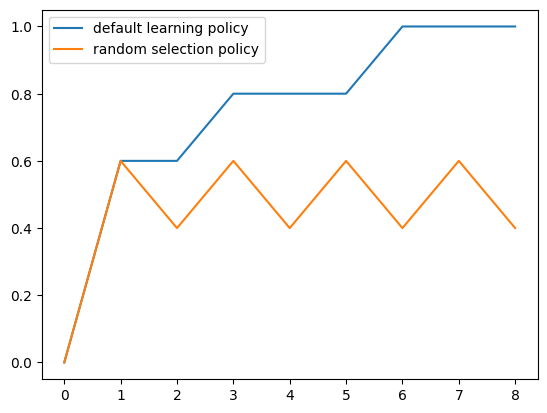

In [25]:
# note matplotlib is not a dependency of langchain so you need to install to plot

# from matplotlib import pyplot as plt
# chain.metrics.to_pandas()['score'].plot(label="default learning policy")
# random_chain.metrics.to_pandas()['score'].plot(label="random selection policy")
# plt.legend()

print(f"The final average score for the default policy, calculated over a rolling window, is: {chain.metrics.to_pandas()['score'].iloc[-1]}")
print(f"The final average score for the random policy, calculated over a rolling window, is: {random_chain.metrics.to_pandas()['score'].iloc[-1]}")

There is a bit of randomness involved in the rl_chain's selection since the chain explores the selection space in order to learn the world as best as it can (see details of default exploration algorithm used [here](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Contextual-Bandit-Exploration-with-SquareCB)), but overall, default chain policy should be doing better than random as it learns

## Advanced options

The rl chain is highly configurable in order to be able to adjust to various selection scenarios. If you want to learn more about the ML library that powers it please take a look at tutorials [here](https://vowpalwabbit.org/)


| Section | Description | Example / Usage |
|---------|-------------|-----------------|
| [**Set Chain Logging Level**](#set-chain-logging-level) | Set up the logging level for the RL chain. | `logger.setLevel(logging.INFO)` |
| [**Featurization**](#featurization) | Adjusts the input to the RL chain. Can set auto-embeddings ON for more complex embeddings. | `chain = rl_chain.PickBest.from_llm(auto_embed=True, [...])` |
| [**Learned Policy to Learn Asynchronously**](#learned-policy-to-learn-asynchronously) | Score asynchronously if user input is needed for scoring. | `chain.update_with_delayed_score(score=<the score>, chain_response=response)` |
| [**Store Progress of Learned Policy**](#store-progress-of-learned-policy) | Option to store the progress of the variable injection learned policy. | `chain.save_progress()` |
| [**Stop Learning of Learned Policy**](#stop-learning-of-learned-policy) | Toggle the RL chain's learned policy updates ON/OFF. | `chain.deactivate_selection_scorer()` |
| [**Set a Different Policy**](#set-a-different-policy) | Choose between different policies: default, random, or custom. | Custom policy creation at chain creation time. |
| [**Different Exploration Algorithms for Default Learned Policy**](#different-exploration-algorithms-for-the-default-learned-policy) | Set different exploration algorithms and hyperparameters for `VwPolicy`. | `vw_cmd = ["--cb_explore_adf", "--quiet", "--squarecb", "--interactions=::"]` |
| [**Learn Policy's Data Logs**](#learn-policys-data-logs) | Store and examine `VwPolicy`'s data logs. | `chain = rl_chain.PickBest.from_llm(vw_logs=<path to log FILE>, [...])` |
| [**Other Advanced Featurization Options**](#other-advanced-featurization-options) | Specify advanced featurization options for the RL chain. | `age = rl_chain.BasedOn("age:32")` |
| [**More Info on Auto or Custom SelectionScorer**](#more-info-on-auto-or-custom-selectionscorer) | Dive deeper into how selection scoring is determined. | `selection_scorer=rl_chain.AutoSelectionScorer(llm=llm, scoring_criteria_template_str=scoring_criteria_template)` |

### set chain logging level

```
import logging
logger = logging.getLogger("rl_chain")
logger.setLevel(logging.INFO)
```

### featurization

By default the input to the rl chain (`ToSelectFrom`, `BasedOn`) is not tampered with. This might  not be sufficient featurization, so based on how complex the scenario is you can set auto-embeddings to ON

`chain = rl_chain.PickBest.from_llm(auto_embed=True, [...])`

This will produce more complex embeddings and featurizations of the inputs, likely accelerating RL chain learning, albeit at the cost of increased runtime..

By default, [sbert.net's sentence_transformers's ](https://www.sbert.net/docs/pretrained_models.html#model-overview) `all-mpnet-base-v2` model will be used for these embeddings but you can set a different model by initializing the chain with it, or set an entirely different encoding object as long as it has an `encode` function that returns a list of the encodings:

```
from sentence_transformers import SentenceTransformer

chain = rl_chain.PickBest.from_llm(
    [...]
    feature_embedder=rl_chain.PickBestFeatureEmbedder(
        auto_embed=True,
        model=SentenceTransformer("all-mpnet-base-v2")
    )
)
```

Another option is to define what inputs you think should be embedded manually:
- `auto_embed = False`
- Can wrap individual variables in `rl_chain.Embed()` or `rl_chain.EmbedAndKeep()` e.g. `user = rl_chain.BasedOn(rl_chain.Embed("Tom"))`

Final option is to define and set your own feature embedder that returns a valid input for the learned policy.

## learned policy to learn asynchronously

If to score the result you need input from the user (e.g. my application showed Tom the selected meal and Tom clicked on it, but Anna did not), then the scoring can be done asynchronously. The way to do that is:

- set `selection_scorer=None` on the chain creation OR call `chain.deactivate_selection_scorer()`
- call the chain for a specific input
- keep the chain's response (`response = chain.run([...])`)
- once you have determined the score of the response/chain selection call the chain with it: `chain.update_with_delayed_score(score=<the score>, chain_response=response)`

### store progress of learned policy

Since the variable injection learned policy evolves over time, there is the option to store its progress and continue learning. This can be done by calling:

`chain.save_progress()`

which will store the rl chain's learned policy in a file called `latest.vw`. It will also store it in a file with a timestamp. That way, if `save_progress()` is called more than once, multiple checkpoints will be created, but the latest one will always be in `latest.vw`

Next time the chain is loaded, the chain will look for a file called `latest.vw` and if the file exists it will be loaded into the chain and the learning will continue from there.

By default the rl chain model checkpoints will be stored in the current directory but you can specify the save/load location at chain creation time:

`chain = rl_chain.PickBest.from_llm(model_save_dir=<path to dir>, [...])`

### stop learning of learned policy

If you want the rl chain's learned policy to stop updating you can turn it off/on:

`chain.deactivate_selection_scorer()` and `chain.activate_selection_scorer()`

### set a different policy

There are two policies currently available:

- default policy: `VwPolicy` which learns a [Vowpal Wabbit](https://github.com/VowpalWabbit/vowpal_wabbit) [Contextual Bandit](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Contextual-Bandit-algorithms) model

- random policy: `RandomPolicy` which doesn't learn anything and just selects a value randomly. this policy can be used to compare other policies with a random baseline one.

- custom policies: a custom policy could be created and set at chain creation time

### different exploration algorithms for the default learned policy

The default `VwPolicy` is initialized with some default arguments. The default exploration algorithm is [SquareCB](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Contextual-Bandit-Exploration-with-SquareCB) but other Contextual Bandit exploration algorithms can be set, and other hyper parameters can be set also:

`vw_cmd = ["--cb_explore_adf", "--quiet", "--squarecb", "--interactions=::"]`

`chain = rl_chain.PickBest.from_llm(vw_cmd = vw_cmd, [...])`

### learn policy's data logs

The `VwPolicy`'s data files can be stored and examined or used to do [off policy evaluation](https://vowpalwabbit.org/docs/vowpal_wabbit/python/latest/tutorials/off_policy_evaluation.html) for hyper parameter tuning.

The way to do this is to set a log file path to `vw_logs` on chain creation:

`chain = rl_chain.PickBest.from_llm(vw_logs=<path to log FILE>, [...])`

### other advanced featurization options

Explictly numerical features can be provided with a colon separator:
`age = rl_chain.BasedOn("age:32")`

`ToSelectFrom` can be a bit more complex if the scenario demands it, instead of being a list of strings it can be:
- a list of list of strings:
    ```
    meal = rl_chain.ToSelectFrom([
        ["meal 1 name", "meal 1 description"],
        ["meal 2 name", "meal 2 description"]
    ])
    ```
- a list of dictionaries:
    ```
    meal = rl_chain.ToSelectFrom([
        {"name":"meal 1 name", "description" : "meal 1 description"},
        {"name":"meal 2 name", "description" : "meal 2 description"}
    ])
    ```
- a list of dictionaries containing lists:
    ```
    meal = rl_chain.ToSelectFrom([
        {"name":["meal 1", "complex name"], "description" : "meal 1 description"},
        {"name":["meal 2", "complex name"], "description" : "meal 2 description"}
    ])
    ```

`BasedOn` can also take a list of strings:
```
user = rl_chain.BasedOn(["Tom Joe", "age:32", "state of california"])
```

there is no dictionary provided since multiple variables can be supplied wrapped in `BasedOn`

Storing the data logs into a file allows the examination of what different inputs do to the data format.

### More info on Auto or Custom SelectionScorer

The selection scorer is very important to get right since the policy uses it to learn. It determines what is called the reward in reinforcement learning, and more specifically in our Contextual Bandits setting.

The general advice is to keep the score between [0, 1], 0 being the worst selection, 1 being the best selection from the available `ToSelectFrom` variables, based on the `BasedOn` variables, but should be adjusted if the need arises.

In the examples provided above, the AutoSelectionScorer is set mostly to get users started but in real world scenarios it will most likely not be an adequate scorer function.

The example also provided the option to change part of the scoring prompt template that the AutoSelectionScorer used to determine whether a selection was good or not:

```
scoring_criteria_template = "Given {preference} rank how good or bad this selection is {meal}"
chain = rl_chain.PickBest.from_llm(
    llm=llm,
    prompt=PROMPT,
    selection_scorer=rl_chain.AutoSelectionScorer(llm=llm, scoring_criteria_template_str=scoring_criteria_template),
)

```

Internally the AutoSelectionScorer adjusted the scoring prompt to make sure that the llm scoring retured a single float.

However, if needed, a FULL scoring prompt can also be provided:


In [17]:
from langchain.prompts.prompt import PromptTemplate
import langchain
langchain.debug = True

REWARD_PROMPT_TEMPLATE = """Given {preference} rank how good or bad this selection is {meal}, IMPORANT: you MUST return a single number between -1 and 1, -1 being bad, 1 being good"""


REWARD_PROMPT = PromptTemplate(
    input_variables=["preference", "meal"],
    template=REWARD_PROMPT_TEMPLATE,
)

chain = rl_chain.PickBest.from_llm(
    llm=llm,
    prompt=PROMPT,
    selection_scorer=rl_chain.AutoSelectionScorer(llm=llm, prompt=REWARD_PROMPT),
)

chain.run(
    meal = rl_chain.ToSelectFrom(meals),
    user = rl_chain.BasedOn("Tom"),
    preference = rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),
    text_to_personalize = "This is the weeks specialty dish, our master chefs believe you will love it!",
)

[chain/start] [1:chain:PickBest] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:PickBest > 2:chain:LLMChain] Entering Chain run with input:
[inputs]
[llm/start] [1:chain:PickBest > 2:chain:LLMChain > 3:llm:OpenAI] Entering LLM run with input:
{
  "prompts": [
    "Here is the description of a meal: \"Beef Enchiladas with Feta cheese. Mexican-Greek fusion\".\n\nEmbed the meal into the given text: \"This is the weeks specialty dish, our master chefs believe you will love it!\".\n\nPrepend a personalized message including the user's name Tom and their preference ['Vegetarian', 'regular dairy is ok'].\n\nMake it sound good."
  ]
}
[llm/end] [1:chain:PickBest > 2:chain:LLMChain > 3:llm:OpenAI] [1.63s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "\nHey Tom, we have a special treat this week! Our master chefs have created a Mexican-Greek fusion dish of Beef Enchiladas with Feta cheese - perfect for those who enjoy vegetarian options and can 

{'response': "Hey Tom, we have a special treat this week! Our master chefs have created a Mexican-Greek fusion dish of Beef Enchiladas with Feta cheese - perfect for those who enjoy vegetarian options and can enjoy regular dairy. We know you're going to love it!",
 'selection_metadata': <langchain.chains.rl_chain.pick_best_chain.PickBestEvent at 0x7fcf4c4147f0>}